In [1]:
import pandas as pd

# Upload files manually in Colab using:
from google.colab import files
files.upload()

# Load datasets
df_mort_ca = pd.read_csv('hd_mortalitybyca.csv')
df_act_ca = pd.read_csv('hd_activitybyca.csv')

In [2]:
# Column descriptions based on Scottish Health and Social Care Open Data:
# 'CA' = Council Area code (geographic region)
# 'AgeGroup' = Age bracket for individuals (e.g., '0-44 years')
# 'Sex' = Gender category (Males/Females)
# 'CrudeRate_act' = Crude rate of CHD hospital discharges
# 'NumberOfDischarges' = Total CHD hospital discharges
# 'EASR_mort' = European Age-Standardised Mortality Rate (target variable)
# 'CrudeRateQF' / 'NumberOfDischargesQF' = Quality Flags indicating uncertainty or suppression# SECTION 1: Load and Preprocess Council Area Dataset
# Convert FinancialYear to integer 'Year'
df_act_ca['Year'] = df_act_ca['FinancialYear'].str[:4].astype(int)

# Merge both datasets on common keys
def prepare_dataset(df_mort, df_act, keys):
    merged = pd.merge(df_mort, df_act, how='inner', left_on=keys, right_on=keys, suffixes=('_mort', '_act'))
    df_model = merged[[
        'Year', 'AgeGroup', 'Sex', 'CA',
        'CrudeRate_act', 'NumberOfDischarges',
        'EASR_mort'
    ]].dropna()
    return df_model

df_ca = prepare_dataset(df_mort_ca, df_act_ca, ['Year', 'CA', 'AgeGroup', 'Sex'])
qf_cols = [col for col in df_ca.columns if 'QF' in col]
print("Detected QF Columns:", qf_cols)

if qf_cols:
    print("\nMissing values per QF column:")
    print(df_ca[qf_cols].isnull().sum())

    print("\nSample value distributions in QF columns:")
    for col in qf_cols:
        print(f"{col} value counts:\n", df_ca[col].value_counts(dropna=False), "\n")

# Preview the final merged dataset
df_ca.head()

Detected QF Columns: []


,Year,AgeGroup,Sex,CA,CrudeRate_act,NumberOfDischarges,EASR_mort
0,2013,0-44 years,Males,S92000003,84.137824,1226.0,6.24869
1,2013,0-44 years,Males,S92000003,12.696164,185.0,6.24869
2,2013,0-44 years,Males,S92000003,31.568841,460.0,6.24869
3,2013,0-44 years,Males,S92000003,39.872819,581.0,6.24869
4,2013,0-44 years,Males,S92000003,58.059216,846.0,6.24869


               Year  CrudeRate_act  NumberOfDischarges     EASR_mort
count  82539.000000   82539.000000        82539.000000  82539.000000
mean    2017.567514     168.972178          512.058736     87.036128
std        2.864751     318.434169         2146.351021    173.092592
min     2013.000000       0.000000            0.000000      0.000000
25%     2015.000000       0.000000            0.000000      3.221412
50%     2018.000000      36.348973           34.000000     36.435274
75%     2020.000000     215.088027          233.000000    104.905478
max     2022.000000    5063.734958        51473.000000   2409.366051


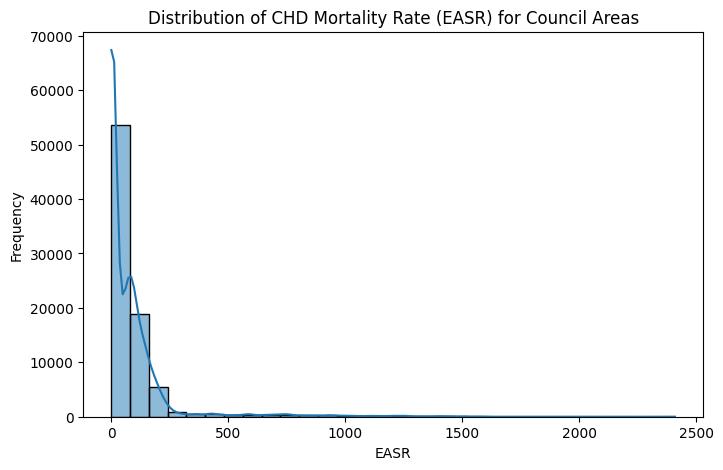

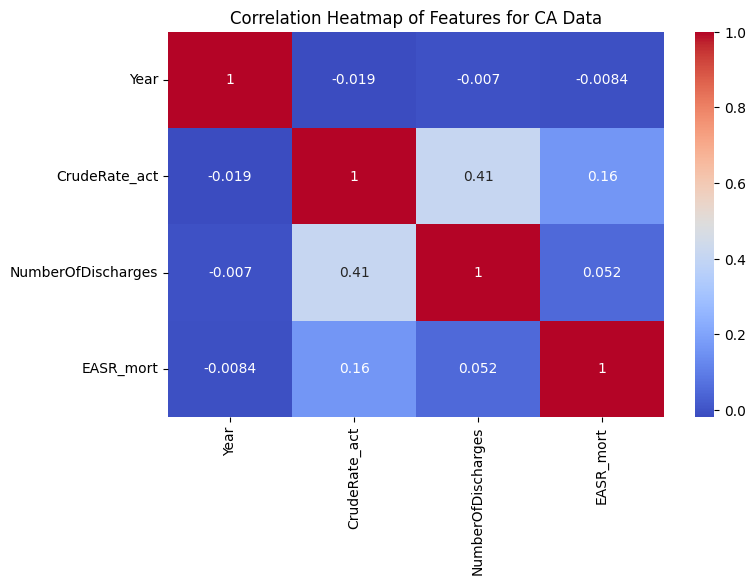

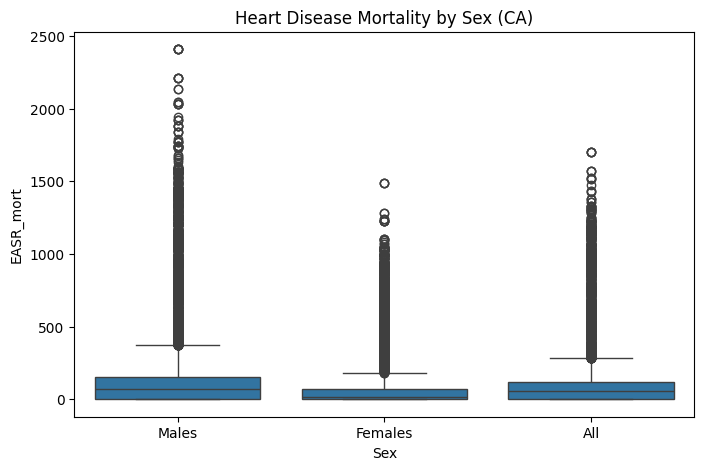

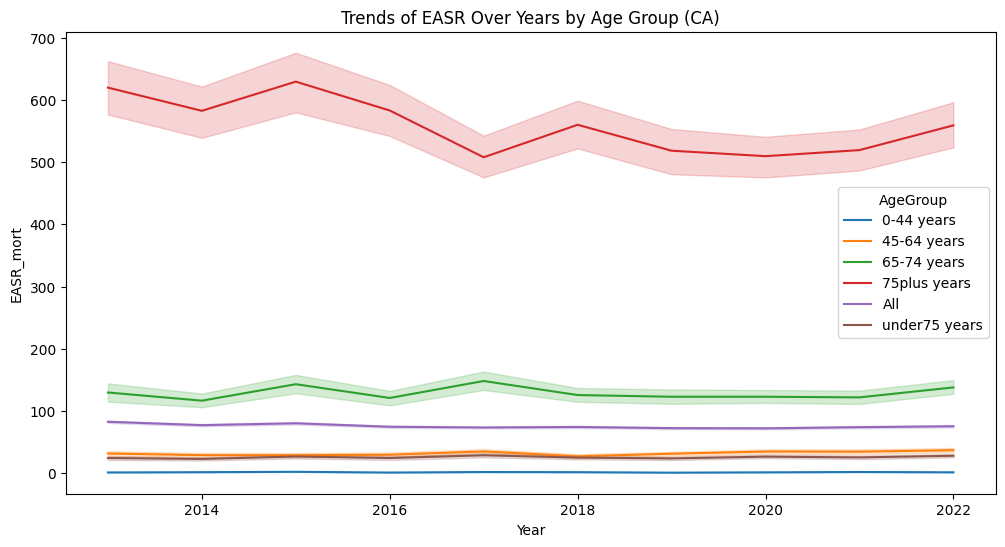

In [3]:
# SECTION 2: Exploratory Data Analysis (EDA)

import seaborn as sns
import matplotlib.pyplot as plt

# Basic statistics
print(df_ca.describe())

# Distribution of Target Variable
plt.figure(figsize=(8,5))
sns.histplot(df_ca['EASR_mort'], bins=30, kde=True)
plt.title("Distribution of CHD Mortality Rate (EASR) for Council Areas")
plt.xlabel("EASR")
plt.ylabel("Frequency")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df_ca.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Features for CA Data")
plt.show()

# Boxplot by Sex
plt.figure(figsize=(8,5))
sns.boxplot(x='Sex', y='EASR_mort', data=df_ca)
plt.title("Heart Disease Mortality by Sex (CA)")
plt.show()

# Lineplot by Year and Age Group
plt.figure(figsize=(12,6))
sns.lineplot(data=df_ca, x='Year', y='EASR_mort', hue='AgeGroup')
plt.title("Trends of EASR Over Years by Age Group (CA)")
plt.show()

In [4]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 89.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


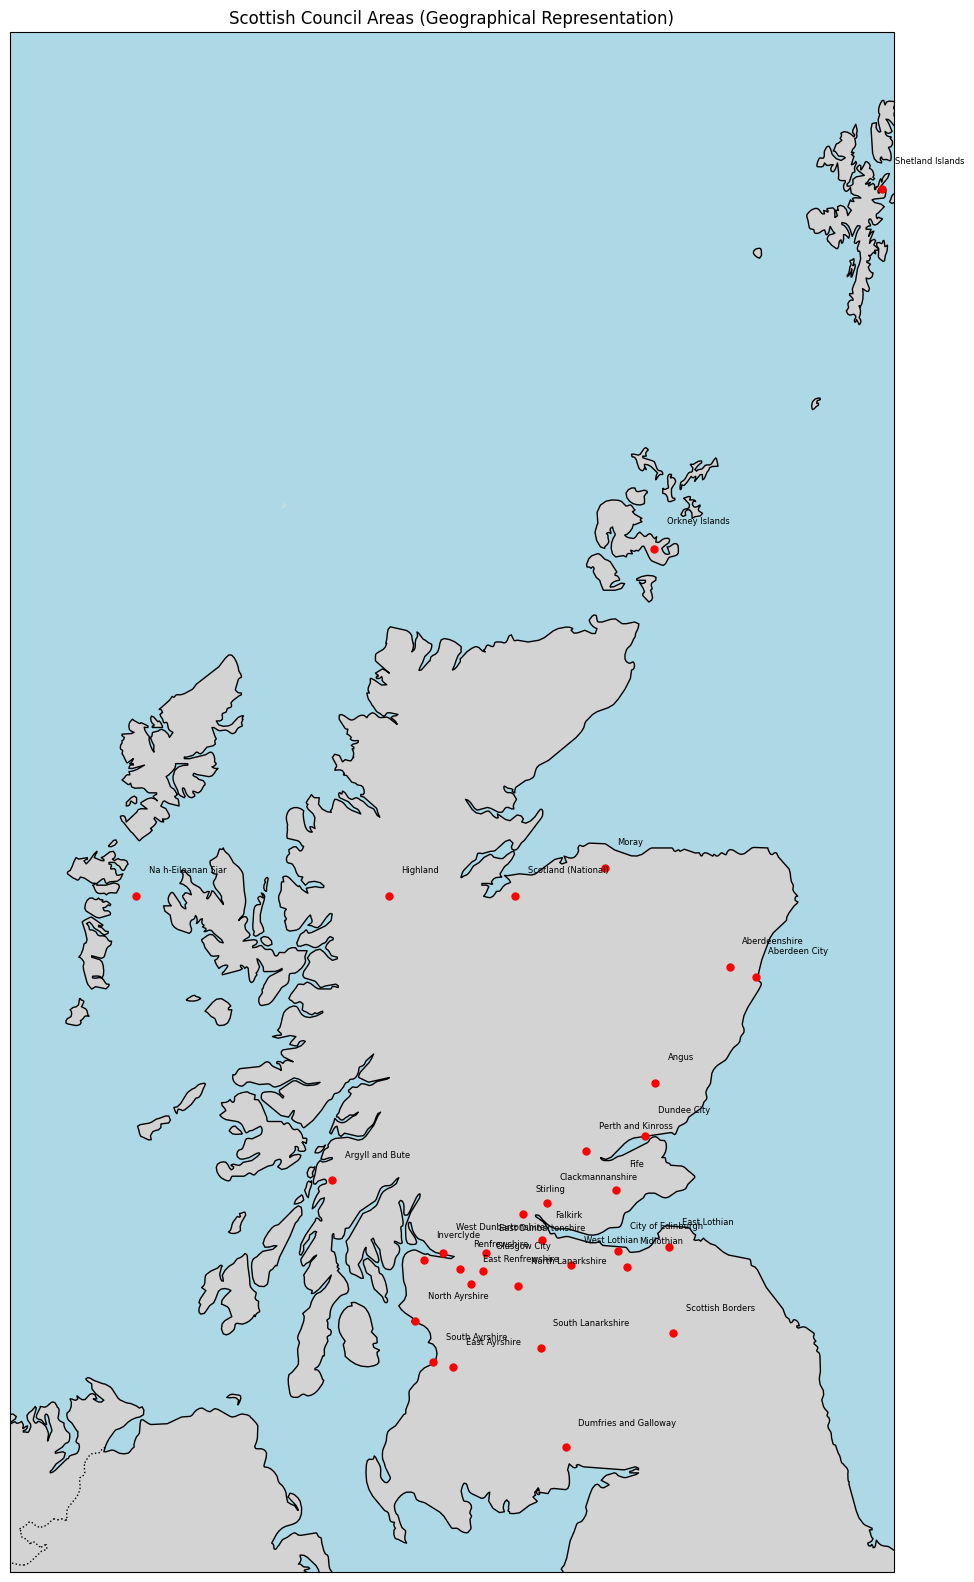

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Dictionary with coordinates
council_area_coords = {
    "S12000005": {"name": "Clackmannanshire", "lat": 56.16667, "lon": -3.75000},
    "S12000006": {"name": "Dumfries and Galloway", "lat": 55.07000, "lon": -3.60000},
    "S12000008": {"name": "East Ayrshire", "lat": 55.43400, "lon": -4.48900},
    "S12000010": {"name": "East Dunbartonshire", "lat": 55.94400, "lon": -4.22600},
    "S12000011": {"name": "East Lothian", "lat": 55.97000, "lon": -2.78000},
    "S12000013": {"name": "East Renfrewshire", "lat": 55.80700, "lon": -4.35000},
    "S12000014": {"name": "City of Edinburgh", "lat": 55.95335, "lon": -3.18837},
    "S12000017": {"name": "Falkirk", "lat": 56.00000, "lon": -3.78300},
    "S12000018": {"name": "Fife", "lat": 56.22500, "lon": -3.20000},
    "S12000019": {"name": "Glasgow City", "lat": 55.86423, "lon": -4.25180},
    "S12000020": {"name": "Highland", "lat": 57.50000, "lon": -5.00000},
    "S12000021": {"name": "Inverclyde", "lat": 55.91300, "lon": -4.72400},
    "S12000023": {"name": "Midlothian", "lat": 55.88400, "lon": -3.11600},
    "S12000026": {"name": "Moray", "lat": 57.61600, "lon": -3.29000},
    "S12000027": {"name": "Na h‑Eileanan Siar", "lat": 57.50000, "lon": -7.00000},
    "S12000028": {"name": "North Ayrshire", "lat": 55.64200, "lon": -4.78900},
    "S12000029": {"name": "North Lanarkshire", "lat": 55.79700, "lon": -3.97700},
    "S12000030": {"name": "Orkney Islands", "lat": 58.95000, "lon": -2.90000},
    "S12000033": {"name": "Perth and Kinross", "lat": 56.39500, "lon": -3.43700},
    "S12000034": {"name": "Renfrewshire", "lat": 55.87400, "lon": -4.43500},
    "S12000035": {"name": "Scottish Borders", "lat": 55.58500, "lon": -2.74500},
    "S12000036": {"name": "Shetland Islands", "lat": 60.39000, "lon": -1.09000},
    "S12000038": {"name": "South Ayrshire", "lat": 55.45800, "lon": -4.65000},
    "S12000039": {"name": "South Lanarkshire", "lat": 55.51900, "lon": -3.79600},
    "S12000040": {"name": "Stirling", "lat": 56.11600, "lon": -3.93600},
    "S12000041": {"name": "West Dunbartonshire", "lat": 55.94600, "lon": -4.56700},
    "S12000042": {"name": "West Lothian", "lat": 55.88900, "lon": -3.55500},
    "S12000045": {"name": "Aberdeen City", "lat": 57.14965, "lon": -2.09428},
    "S12000047": {"name": "Aberdeenshire", "lat": 57.19500, "lon": -2.30000},
    "S12000048": {"name": "Angus", "lat": 56.69300, "lon": -2.89000},
    "S12000049": {"name": "Dundee City", "lat": 56.46200, "lon": -2.97000},
    "S12000050": {"name": "Argyll and Bute", "lat": 56.26600, "lon": -5.45000},
    "S92000003": {"name": "Scotland (National)", "lat": 57.50000, "lon": -4.00000}
}

# Create the map
fig = plt.figure(figsize=(30, 20))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([-8, -1, 54.5, 61], crs=ccrs.PlateCarree())

# Add basic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot each council area as a point
for code, info in council_area_coords.items():
    ax.plot(info['lon'], info['lat'],
            marker='o', color='red', markersize=5,
            transform=ccrs.PlateCarree())
    ax.text(info['lon'] + 0.1, info['lat'] + 0.1,
            info['name'], fontsize=6,
            transform=ccrs.PlateCarree())

plt.title("Scottish Council Areas (Geographical Representation)", fontsize=12)
plt.show()


In [15]:
import folium
from folium import plugins
import pandas as pd

# Convert council_area_coords dictionary to a DataFrame
data = []
for code, info in council_area_coords.items():
    record_count = df_ca[df_ca['CA'] == code].shape[0] if code in df_ca['CA'].values else 0
    data.append({
        'code': code,
        'name': info['name'],
        'lat': info['lat'],
        'lon': info['lon'],
        'records': record_count
    })

df_map = pd.DataFrame(data)

# Center of Scotland
map_center = [57.0, -4.0]

# Create Folium map
scotland_map = folium.Map(location=map_center, zoom_start=6, tiles="CartoDB positron")

# Color scale based on record counts
max_count = df_map['records'].max()
min_count = df_map['records'].min()

# Add points to map
for _, row in df_map.iterrows():
    color = plt.cm.viridis((row['records'] - min_count) / (max_count - min_count))  # normalized
    color_hex = "#{:02x}{:02x}{:02x}".format(
        int(color[0]*255), int(color[1]*255), int(color[2]*255)
    )

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        popup=f"{row['name']}<br>Records: {row['records']}",
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.7
    ).add_to(scotland_map)

# Display map
scotland_map


/tmp/ipython-input-3553837036.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ca_counts = df_ca.groupby(['Year', 'CA']).size().unstack(fill_value=0)


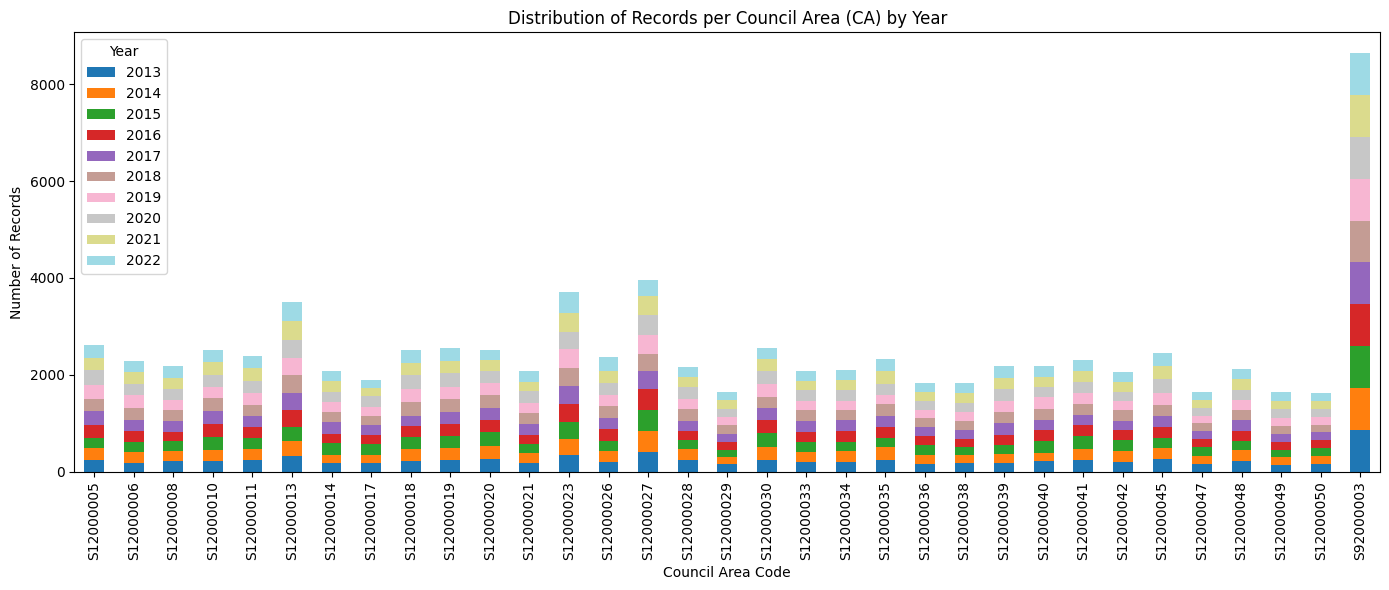

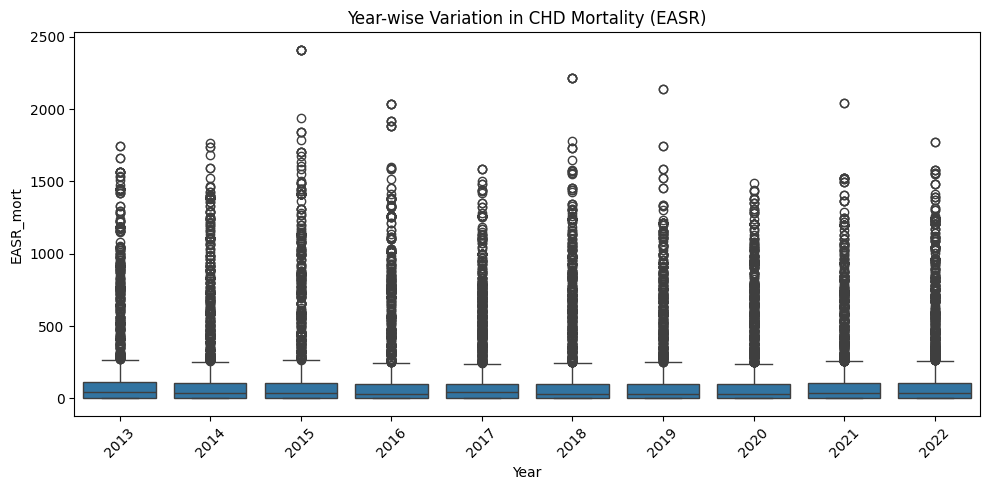

In [16]:
#eda
import matplotlib.pyplot as plt
import seaborn as sns

# Number of records per CA each year
ca_counts = df_ca.groupby(['Year', 'CA']).size().unstack(fill_value=0)
ca_counts.T.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title("Distribution of Records per Council Area (CA) by Year")
plt.xlabel("Council Area Code")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()
# Boxplot to see EASR variations across years
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_ca, x='Year', y='EASR_mort')
plt.title("Year-wise Variation in CHD Mortality (EASR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



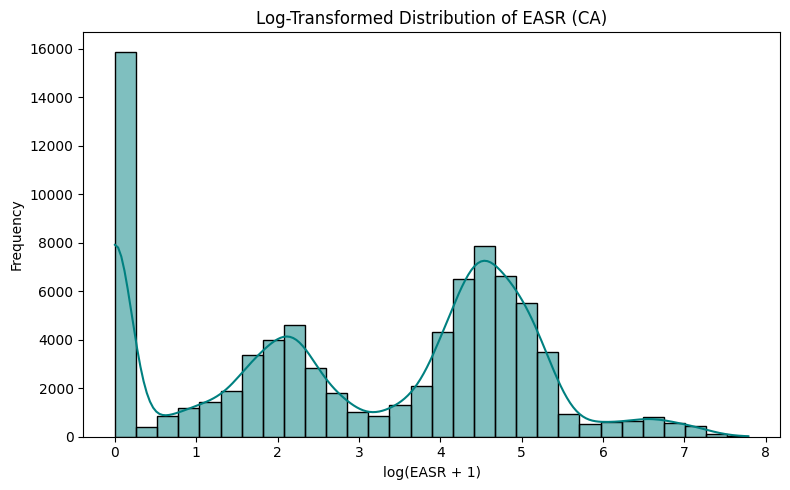

In [17]:
# Log-Transformed Distribution of EASR
import numpy as np
df_ca['Log_EASR'] = np.log1p(df_ca['EASR_mort'])  # log(EASR + 1)

plt.figure(figsize=(8, 5))
sns.histplot(df_ca['Log_EASR'], bins=30, kde=True, color='teal')
plt.title("Log-Transformed Distribution of EASR (CA)")
plt.xlabel("log(EASR + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

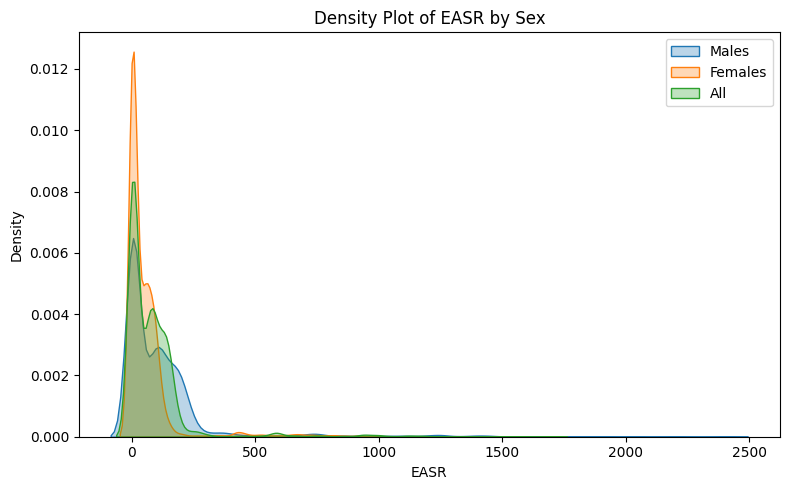

In [18]:
# KDE Plot of EASR by Sex
plt.figure(figsize=(8, 5))
for sex in df_ca['Sex'].unique():
    subset = df_ca[df_ca['Sex'] == sex]
    sns.kdeplot(subset['EASR_mort'], label=sex, fill=True, alpha=0.3)
plt.title("Density Plot of EASR by Sex")
plt.xlabel("EASR")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

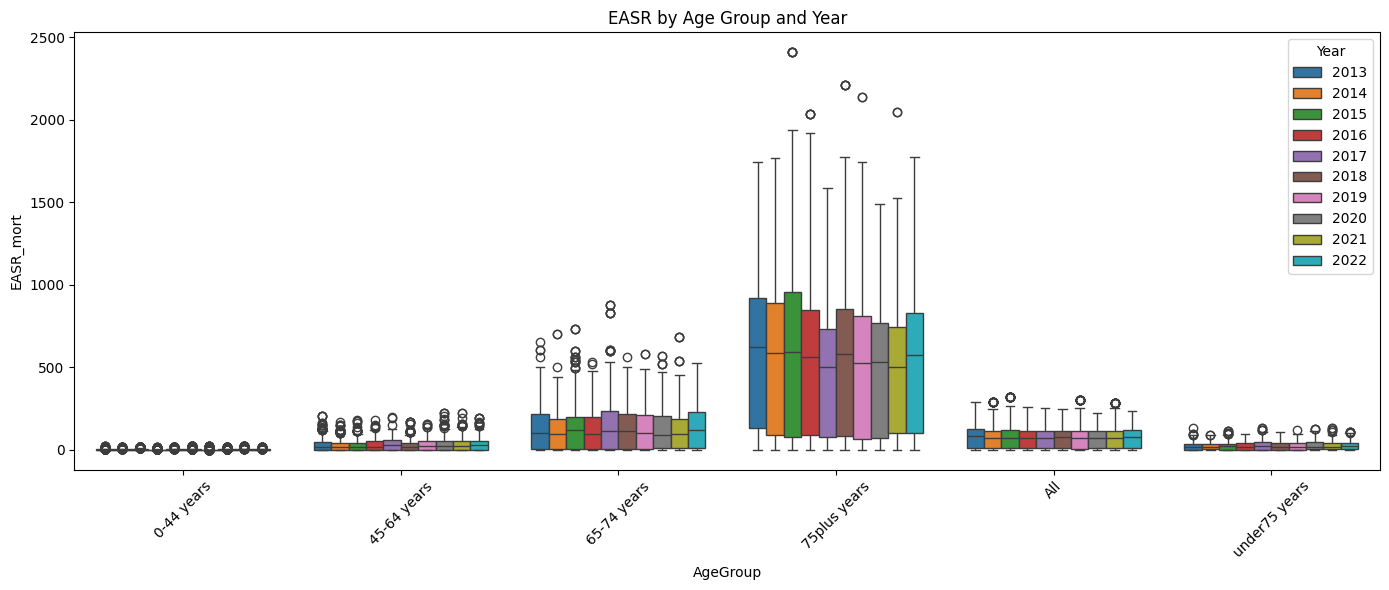

In [19]:
# Boxplot of EASR by Age Group and Year
years_sorted = sorted(df_ca['Year'].unique())
df_ca['Year'] = pd.Categorical(df_ca['Year'], categories=years_sorted, ordered=True)

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_ca,
    x="AgeGroup",
    y="EASR_mort",
    hue="Year",
    hue_order=years_sorted
)
plt.title("EASR by Age Group and Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

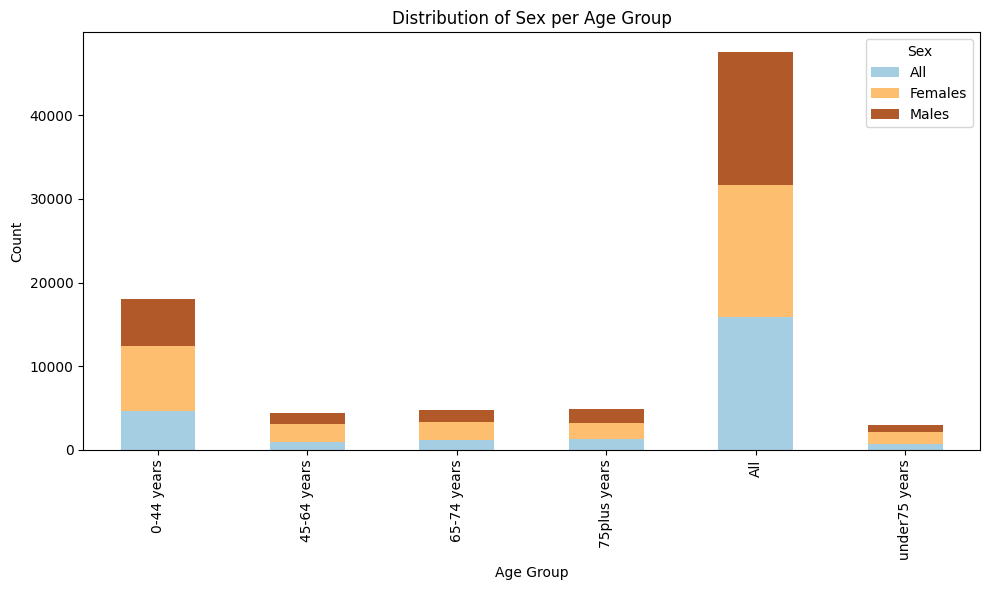

In [20]:
# Stacked Bar Plot of Sex Distribution per Age Group
sex_age_counts = df_ca.groupby(['AgeGroup', 'Sex']).size().unstack(fill_value=0)
sex_age_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Paired')
plt.title("Distribution of Sex per Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

In [21]:
# SECTION 3: Encode Features & Split Data

from sklearn.model_selection import train_test_split

# Drop 'Log_EASR' if present (target transformation should not be used as a predictor)
df_ca_cleaned = df_ca.drop(columns=['Log_EASR']) if 'Log_EASR' in df_ca.columns else df_ca.copy()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_ca_cleaned, columns=['Sex', 'AgeGroup', 'CA'], drop_first=True)

# Define feature set X and target variable y
X = df_encoded.drop('EASR_mort', axis=1)
y = df_encoded['EASR_mort']

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show shapes for verification
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (66031, 42)
Test set shape: (16508, 42)


In [ ]:
# SECTION 4: Model Development with Hyperparameter Tuning

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

models = {
    "Linear Regression": (LinearRegression(), {}),
    "Decision Tree": (DecisionTreeRegressor(random_state=42), {"max_depth": [3,5,7,10]}),
    "Random Forest": (RandomForestRegressor(random_state=42), {"n_estimators": [50,100], "max_depth": [5,10,15]}),
    "Gradient Boosting": (GradientBoostingRegressor(random_state=42), {"n_estimators": [100,200], "learning_rate": [0.05,0.1]}),
    "SVR": (SVR(kernel='rbf'), {"C": [1,10], "epsilon": [0.1,0.2]})
}

best_models = {}
results = []

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2}

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    preds = grid.predict(X_test)
    results.append(evaluate_model(name, y_test, preds))

results_df = pd.DataFrame(results)
print("\nModel Performance Summary (CA):\n", results_df)


Model Performance Summary (CA):
                Model        MAE        RMSE        R²
0  Linear Regression  62.013855  120.153112  0.533261
1      Decision Tree  57.653259  118.865809  0.543208
2      Random Forest  57.512841  117.886977  0.550701
3  Gradient Boosting  58.908711  117.527341  0.553438
4                SVR  75.816037  182.295619 -0.074377



Best Performing Model: Gradient Boosting


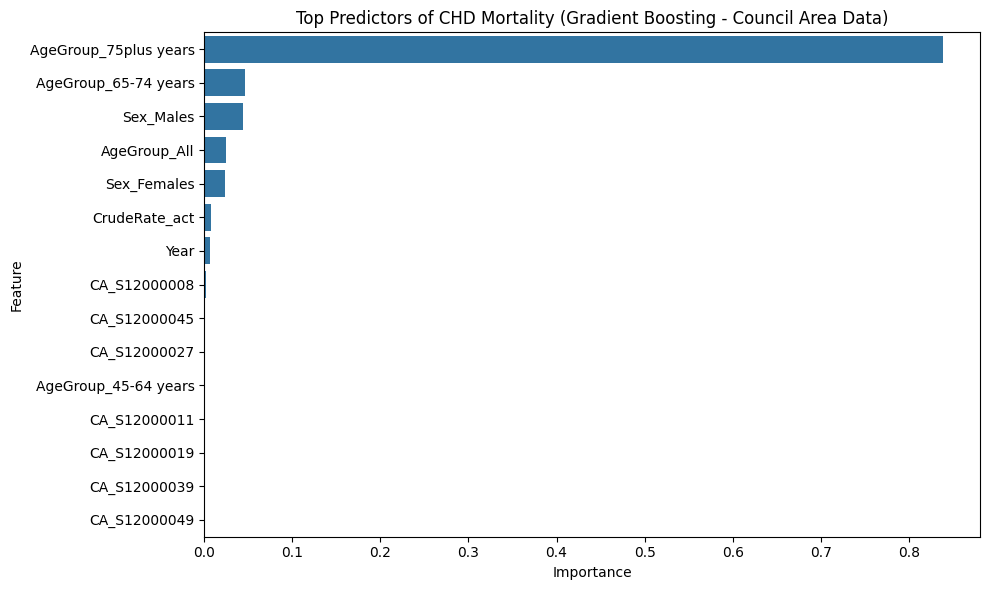

In [ ]:
# SECTION 5: Feature Importance for Best Model

best_model_name = results_df.sort_values(by="R²", ascending=False).iloc[0]["Model"]
print(f"\nBest Performing Model: {best_model_name}")

# Only models that support feature_importances_ will be plotted
if best_model_name in ["Random Forest", "Gradient Boosting", "Decision Tree"]:
    best_model = best_models[best_model_name]
    importance = best_model.feature_importances_

    feature_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    })

    # Remove any target-like features from the importance plot just in case
    feature_df = feature_df[~feature_df['Feature'].str.contains('EASR', case=False)]
    feature_df = feature_df.sort_values(by='Importance', ascending=False).head(15)

    # Plot with improved title
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_df, x='Importance', y='Feature')
    plt.title(f"Top Predictors of CHD Mortality ({best_model_name} - Council Area Data)")
    plt.tight_layout()
    plt.show()